In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-patiennts/data/val_data.csv
/kaggle/input/stroke-patiennts/data/train_data.csv
/kaggle/input/stroke-patiennts/data/test_data.csv


In [1]:
#Imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from tensorflow.keras.models import Sequential,Model
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,Dense,LSTM,Dropout,Conv1D,MaxPooling1D,Flatten,Bidirectional,TimeDistributed,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
warnings.filterwarnings('ignore')
FEATURES=16
TIMESTEPS=4
OUTPUT=1
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
train_df=pd.read_csv("/kaggle/input/stroke-patiennts/data/train_data.csv")
val_df=pd.read_csv("/kaggle/input/stroke-patiennts/data/val_data.csv")
test_df=pd.read_csv('/kaggle/input/stroke-patiennts/data/test_data.csv')

In [4]:
print(train_df.columns)
print(train_df.shape)

Index(['HADM_ID', 'SUBJECT_ID', 'GENDER', 'AGE', 'Admission Weight (Kg)',
       'Height (cm)', 'Heart Rate', 'Non Invasive Blood Pressure diastolic',
       'Non Invasive Blood Pressure mean',
       'Non Invasive Blood Pressure systolic', 'Respiratory Rate', 'stroke',
       'Tachycardia', 'Bradycardia', 'Hypertension', 'Hypotension',
       'Tachypnea', 'Bradypnea'],
      dtype='object')
(207408, 18)


In [5]:
new_columns = [col for col in train_df.columns if col != 'stroke'] + ['stroke']
print(new_columns)

['HADM_ID', 'SUBJECT_ID', 'GENDER', 'AGE', 'Admission Weight (Kg)', 'Height (cm)', 'Heart Rate', 'Non Invasive Blood Pressure diastolic', 'Non Invasive Blood Pressure mean', 'Non Invasive Blood Pressure systolic', 'Respiratory Rate', 'Tachycardia', 'Bradycardia', 'Hypertension', 'Hypotension', 'Tachypnea', 'Bradypnea', 'stroke']


In [7]:
train_df=train_df[new_columns]
val_df=val_df[new_columns]
test_df=test_df[new_columns]

In [8]:
train_df

,HADM_ID,SUBJECT_ID,GENDER,AGE,Admission Weight (Kg),Height (cm),Heart Rate,Non Invasive Blood Pressure diastolic,Non Invasive Blood Pressure mean,Non Invasive Blood Pressure systolic,Respiratory Rate,Tachycardia,Bradycardia,Hypertension,Hypotension,Tachypnea,Bradypnea,stroke
0,100018,58128,0,55,125.0,178.0,65.5,70.2,81.8,122.4,14.00,0,0,0,0,0,0,0
1,100018,58128,0,55,125.0,178.0,66.0,70.2,81.8,122.4,15.75,0,0,0,0,0,0,0
2,100018,58128,0,55,125.0,178.0,70.0,70.2,81.8,122.4,15.75,0,0,0,0,0,0,0
3,100018,58128,0,55,125.0,178.0,82.5,69.4,81.6,123.2,15.00,0,0,0,0,0,0,0
4,100018,58128,0,55,125.0,178.0,99.0,69.4,80.8,124.0,17.50,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207403,178565,46857,1,86,80.0,160.0,69.0,44.6,46.0,127.0,22.00,0,0,0,0,1,0,0
207404,178565,46857,1,86,80.0,160.0,64.0,49.0,73.0,142.0,24.00,0,0,0,0,1,0,0
207405,178565,46857,1,86,80.0,160.0,66.0,43.0,67.0,132.0,16.00,0,0,0,0,0,0,0
207406,178565,46857,1,86,80.0,160.0,67.0,69.6,86.4,140.0,22.00,0,0,0,0,1,0,0


In [9]:
train_df['stroke'].value_counts(normalize=True)

0    0.966983
1    0.033017
Name: stroke, dtype: float64

In [10]:
from sklearn.preprocessing import StandardScaler,RobustScaler
def static_scale(df):
    data=df.copy()
    scaler=RobustScaler()
    static_cols=["AGE",'Admission Weight (Kg)',"Height (cm)"]
    data[static_cols]=scaler.fit_transform(data[static_cols])
    return data,scaler

In [11]:
from sklearn.preprocessing import StandardScaler,RobustScaler
from tqdm import tqdm
def dynamic_scale(df):
    final_df=pd.DataFrame()
    cols=['Heart Rate',
                  'Non Invasive Blood Pressure diastolic', 'Non Invasive Blood Pressure mean',
                 'Non Invasive Blood Pressure systolic', 'Respiratory Rate']
    for hadm in tqdm(df['HADM_ID'].unique()):
        scaler=RobustScaler()
        #extract the dataframe
        hadm_df=df[df['HADM_ID']==hadm]
        #scale the float cols
        hadm_df[cols]=scaler.fit_transform(hadm_df[cols])
#         print(hadm_df)
        final_df = pd.concat([final_df,hadm_df])
    return final_df

In [12]:
static_cols=["AGE",'Admission Weight (Kg)',"Height (cm)"]
scaled_train,scaler=static_scale(train_df)
val_df[static_cols]=scaler.transform(val_df[static_cols])
test_df[static_cols]=scaler.transform(test_df[static_cols])

In [13]:
scaled_train=dynamic_scale(scaled_train)
val_df=dynamic_scale(val_df)
test_df=dynamic_scale(test_df)

100%|██████████| 216/216 [00:01<00:00, 143.86it/s]


In [14]:
#apply this function for eacxh unique admission
#so we won't mix timestamps from different admission in the same training sequence
def create_window(df):
    n_observation=4
    n_forecast=2
    n_target=1
    X,y=[],[]
    for adm_id in tqdm(df['HADM_ID'].unique()):
        data=df[df['HADM_ID']==adm_id]
#         target_cols=["stroke"]
#         target_df=data[target_cols]
    #     data.drop(target_cols,axis=1,inplace=True)
        for i in range(len(data)-8):
            X.append(data.iloc[i:i+n_observation,2:])
            y.append(data.iloc[i+n_observation+n_forecast:i+n_observation+n_forecast+n_target,-1])
    return np.array(X),np.array(y)

In [2]:
def build_lstm(timesteps,feats,output):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, feats)))
    model.add(LSTM(32))
    model.add(Dense(output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])
    print(model.summary())
    return model

In [55]:
def build_cnn(timesteps,feats,output):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps,feats)))
    #model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])
    print(model.summary())
    return model
    

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense
def build_gru(timesteps, feats, output):
    model = Sequential()
    model.add(Bidirectional(GRU(64, return_sequences=True), input_shape=(timesteps, feats)))
    model.add(GRU(32))
    model.add(Dense(output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])
    print(model.summary())
    return model


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 4, 128)           31488     
 nal)                                                            
                                                                 
 gru_3 (GRU)                 (None, 32)                15552     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 47,073
Trainable params: 47,073
Non-trainable params: 0
_________________________________________________________________
None


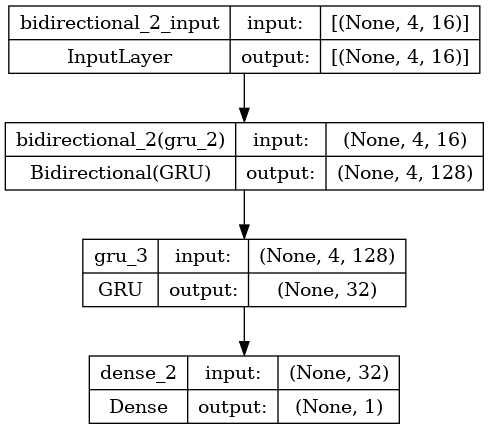

In [6]:
from keras.utils.vis_utils import plot_model
gru=build_gru(TIMESTEPS,FEATURES,OUTPUT)
plot_model(gru, to_file='/kaggle/working/gru_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 4, 128)           41472     
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 62,113
Trainable params: 62,113
Non-trainable params: 0
_________________________________________________________________
None


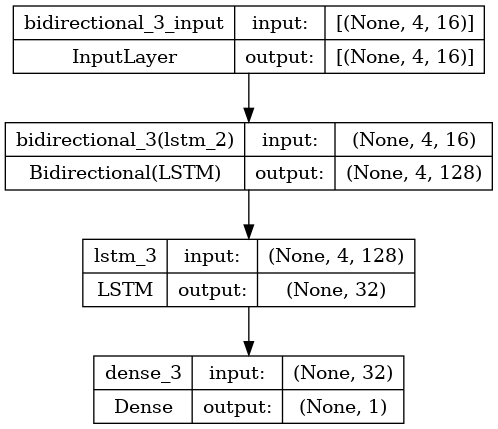

In [7]:
from keras.utils.vis_utils import plot_model
lstm=build_lstm(TIMESTEPS,FEATURES,OUTPUT)
plot_model(lstm, to_file='/kaggle/working/lstm_plot.png', show_shapes=True, show_layer_names=True)

### Custom model separate dynamic and static feats

In [37]:
# RNN + SLP
n_static=4
n_timesteps=4
n_dynamic=12
n_output=1

#Define input layer
recurrent_input = Input(shape=(n_timesteps,n_dynamic),name="TIMESERIES_INPUT")
static_input = Input(shape=(n_static, ),name="STATIC_INPUT")

# RNN Layers
# layer - 1
rec_layer_one = Bidirectional(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),return_sequences=True),name ="BIDIRECTIONAL_LAYER_1")(recurrent_input)
rec_layer_one = Dropout(0.1,name ="DROPOUT_LAYER_1")(rec_layer_one)
# layer - 2
rec_layer_two = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),name ="BIDIRECTIONAL_LAYER_2")(rec_layer_one)
rec_layer_two = Dropout(0.1,name ="DROPOUT_LAYER_2")(rec_layer_two)

# SLP Layers
static_layer_one = Dense(64,  kernel_regularizer=l2(0.001),  activation='relu',name="DENSE_LAYER_1")(static_input)
# Combine layers - RNN + SLP
combined = Concatenate(axis= 1,name = "CONCATENATED_TIMESERIES_STATIC")([rec_layer_two,static_layer_one])
combined_dense_two = Dense(64, activation='relu',name="DENSE_LAYER_2")(combined)
output = Dense(n_output,activation='sigmoid',name="OUTPUT_LAYER")(combined_dense_two)

# Compile ModeL
model = keras.Model(inputs=[recurrent_input,static_input],outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 4, 12)]      0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (Bidirec  (None, 4, 256)      144384      ['TIMESERIES_INPUT[0][0]']       
 tional)                                                                                          
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 4, 256)       0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (Bidirec  (None, 128)         164352      ['DROPOUT_LAYER_1[0][0]']  

In [31]:
def plot(history,metric):
    val="val_"+metric
    df=pd.DataFrame(history.history)[[metric,val]]
    df.plot(figsize=(10,6))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()


In [32]:
def clean_preds(model,data):
    real_predictions=[]
    predictions=model.predict(data)
    for pred in predictions:
        if pred > 0.5:
            real_predictions.append(1)
        else:
            real_predictions.append(0)
    return np.array(real_predictions)
        

In [33]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
def plot_cm (real,preds):
    plt.figure(figsize=(6,6))
    cm = confusion_matrix(real,preds)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in  cm.flatten()] 
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in  zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot=labels,fmt="",cmap='Blues')
    print(classification_report(real, preds))
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
#     plt.title('STEP 1')

In [20]:
neg,pos=np.bincount(train_df['stroke'])
total=neg+pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 207408
    Positive: 6848 (3.30% of total)

Weight for class 0: 0.52
Weight for class 1: 15.14


In [16]:
X_train,y_train=create_window(scaled_train)
X_val,y_val=create_window(val_df)
X_test,y_test=create_window(test_df)
print(X_train.shape," ",y_train.shape)
print(X_val.shape," ",y_val.shape)
print(X_test.shape," ",y_test.shape)

100%|██████████| 216/216 [00:09<00:00, 23.26it/s]


(194376, 4, 16)   (194376, 1)
(24153, 4, 16)   (24153, 1)
(24164, 4, 16)   (24164, 1)


In [17]:
#extracting static feats
X_train_static=X_train[:, 0, :4]
X_val_static=X_val[:,0,:4]
X_test_static=X_test[:,0,:4]

In [39]:
# fit network
custom_history =  model.fit([X_train[:,:,4:],X_train_static],y_train,
epochs=10,
batch_size=32,
validation_data=([X_val[:,:,4:],X_val_static],y_val),
                    class_weight=class_weight)

Epoch 1/10
 816/6075 [===>..........................] - ETA: 1:08 - loss: 0.8660 - accuracy: 0.8683 - precision: 0.1630 - recall: 0.7593 - auc: 0.8697 - prc: 0.3338

KeyboardInterrupt: 

756/756 [==============================] - 5s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     23394
           1       0.16      0.76      0.26       770

    accuracy                           0.86     24164
   macro avg       0.58      0.82      0.59     24164
weighted avg       0.96      0.86      0.90     24164



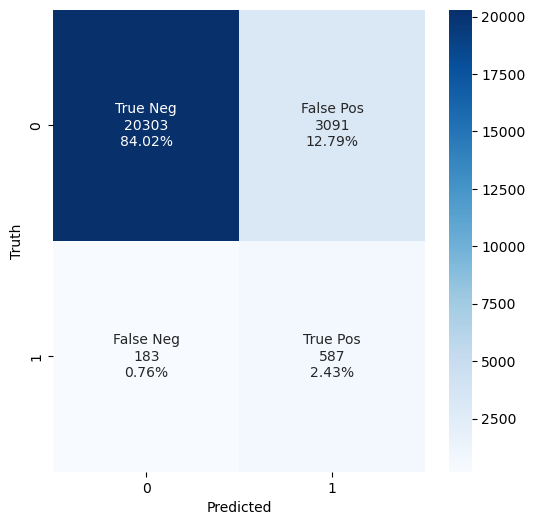

In [24]:
plot_cm(y_test,clean_preds(model,[X_test[:,:,4:],X_test_static]))

In [25]:
model.evaluate([X_test[:,:,4:],X_test_static],y_test)

756/756 [==============================] - 4s 5ms/step - loss: 0.4043 - accuracy: 0.8645


[0.40429380536079407, 0.8645091652870178]

In [26]:
plot(custom_history,'prc')

KeyError: "None of [Index(['prc', 'val_prc'], dtype='object')] are in the [columns]"

In [27]:
plot(custom_history,'precision')

KeyError: "None of [Index(['precision', 'val_precision'], dtype='object')] are in the [columns]"

In [40]:
# fit network
#training for 30 EPOCHS
history2 =  model.fit([X_train[:,:,4:],X_train_static],y_train,
epochs=30,
batch_size=32,
validation_data=([X_val[:,:,4:],X_val_static],y_val),
                    class_weight=class_weight)

Epoch 1/30
6075/6075 [==============================] - 87s 14ms/step - loss: 0.4357 - accuracy: 0.8775 - precision: 0.1783 - recall: 0.7798 - auc: 0.8863 - prc: 0.3850 - val_loss: 0.3345 - val_accuracy: 0.8834 - val_precision: 0.2559 - val_recall: 0.8278 - val_auc: 0.9194 - val_prc: 0.6124
Epoch 2/30
6075/6075 [==============================] - 85s 14ms/step - loss: 0.4195 - accuracy: 0.8736 - precision: 0.1752 - recall: 0.7918 - auc: 0.8900 - prc: 0.4006 - val_loss: 0.3336 - val_accuracy: 0.8925 - val_precision: 0.2699 - val_recall: 0.8086 - val_auc: 0.9191 - val_prc: 0.6366
Epoch 3/30
6075/6075 [==============================] - 85s 14ms/step - loss: 0.4142 - accuracy: 0.8740 - precision: 0.1758 - recall: 0.7920 - auc: 0.8913 - prc: 0.4060 - val_loss: 0.5253 - val_accuracy: 0.8206 - val_precision: 0.1865 - val_recall: 0.8828 - val_auc: 0.9169 - val_prc: 0.6059
Epoch 4/30
6075/6075 [==============================] - 85s 14ms/step - loss: 0.4066 - accuracy: 0.8727 - precision: 0.1748 

756/756 [==============================] - 4s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     23394
           1       0.16      0.73      0.26       770

    accuracy                           0.87     24164
   macro avg       0.57      0.80      0.59     24164
weighted avg       0.96      0.87      0.91     24164



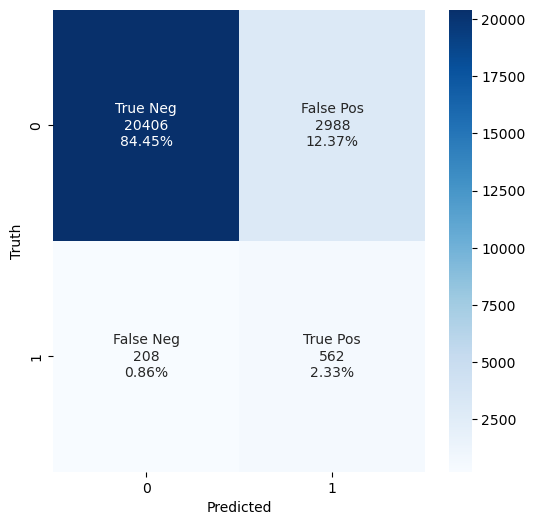

In [41]:
plot_cm(y_test,clean_preds(model,[X_test[:,:,4:],X_test_static]))

In [42]:
model.evaluate([X_test[:,:,4:],X_test_static],y_test)

756/756 [==============================] - 5s 7ms/step - loss: 0.3678 - accuracy: 0.8677 - precision: 0.1583 - recall: 0.7299 - auc: 0.8647 - prc: 0.2814


[0.3677619397640228,
 0.8677371144294739,
 0.15830986201763153,
 0.7298701405525208,
 0.8646804094314575,
 0.28143298625946045]

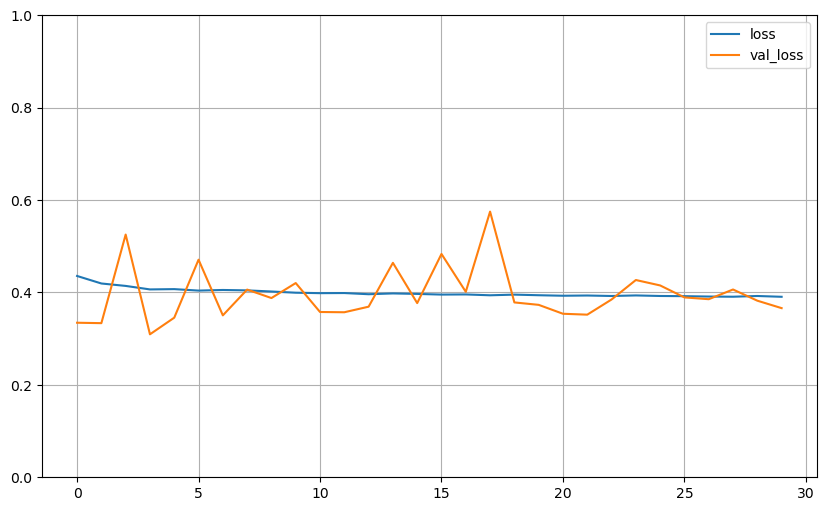

In [50]:
plot(history2,"loss")

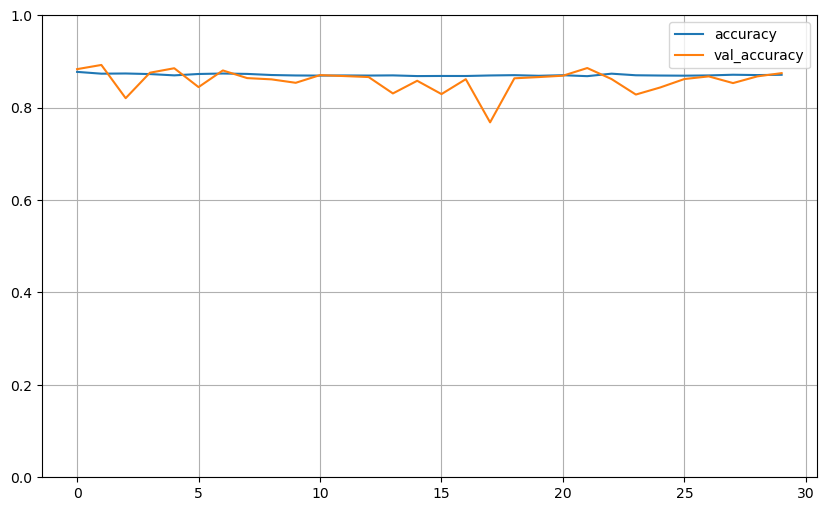

In [52]:
plot(history2,"accuracy")

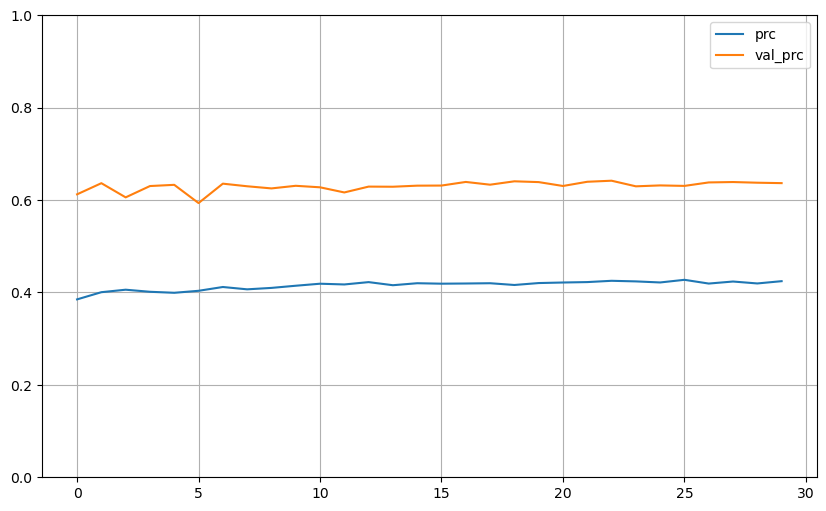

In [43]:
plot(history2,'prc')

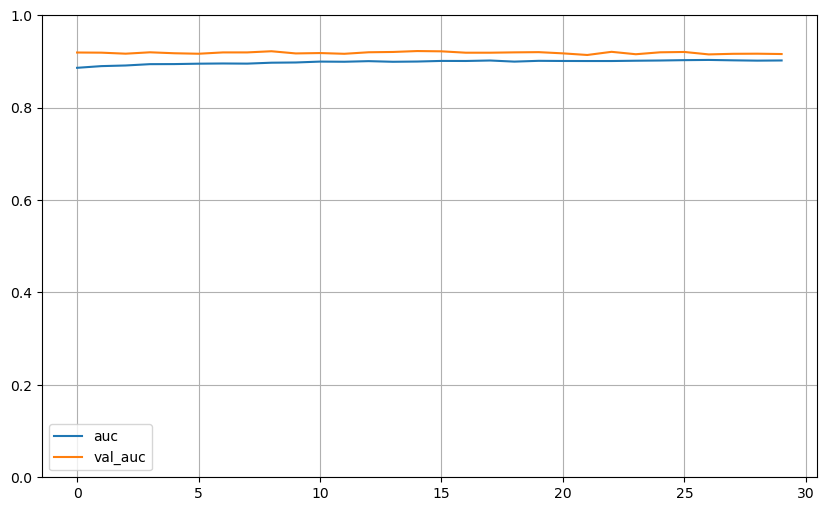

In [47]:
plot(history2,"auc")

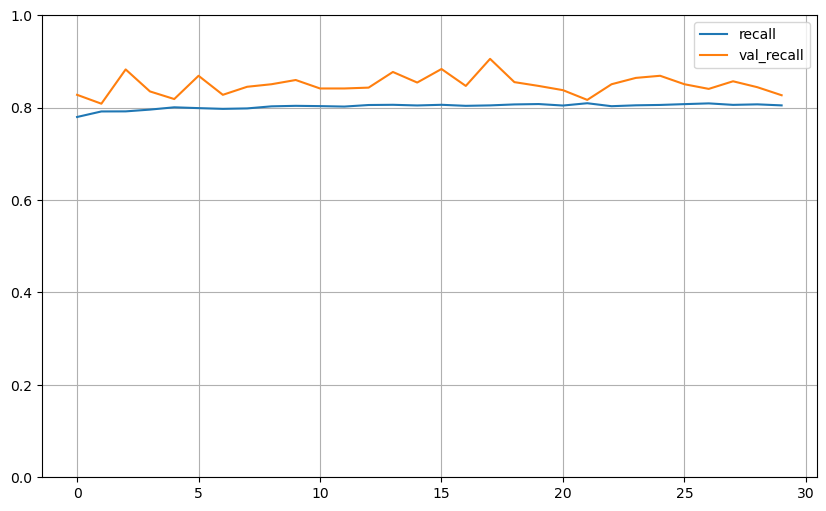

In [48]:
plot(history2,"recall")

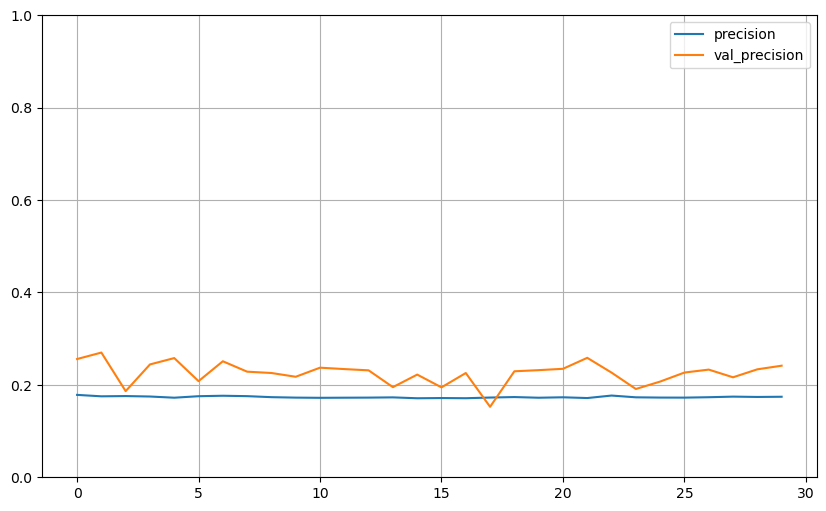

In [49]:
plot(history2,"precision")

## Baseline models

In [35]:
#define metrics_list global varibale
metrics_list=['loss',"accuracy","recall","precision","auc","prc"]

### cnn

In [57]:
cnn_model=build_cnn(TIMESTEPS,FEATURES,OUTPUT)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             3136      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                        

In [59]:
CNN_history=cnn_model.fit(X_train,y_train,epochs=30,batch_size=32,validation_data=(X_val,y_val))

Epoch 1/30
6075/6075 [==============================] - 97s 6ms/step - loss: 2763025664.0000 - accuracy: 0.9712 - precision: 0.6261 - recall: 0.2584 - auc: 0.8699 - prc: 0.4011 - val_loss: 0.1004 - val_accuracy: 0.9713 - val_precision: 0.8112 - val_recall: 0.4762 - val_auc: 0.9125 - val_prc: 0.6360
Epoch 2/30
6075/6075 [==============================] - 37s 6ms/step - loss: 160675440.0000 - accuracy: 0.9719 - precision: 0.6517 - recall: 0.2711 - auc: 0.8896 - prc: 0.4405 - val_loss: 0.1010 - val_accuracy: 0.9712 - val_precision: 0.8523 - val_recall: 0.4386 - val_auc: 0.9142 - val_prc: 0.6388
Epoch 3/30
6075/6075 [==============================] - 38s 6ms/step - loss: 0.0898 - accuracy: 0.9721 - precision: 0.6673 - recall: 0.2634 - auc: 0.8969 - prc: 0.4545 - val_loss: 0.1007 - val_accuracy: 0.9701 - val_precision: 0.8558 - val_recall: 0.4075 - val_auc: 0.9169 - val_prc: 0.6357
Epoch 4/30
6075/6075 [==============================] - 37s 6ms/step - loss: 0.0886 - accuracy: 0.9725 - preci

In [ ]:
cnn_model.evaluate(X_test,y_test)

756/756 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     23394
           1       0.44      0.11      0.18       770

    accuracy                           0.97     24164
   macro avg       0.71      0.55      0.58     24164
weighted avg       0.95      0.97      0.96     24164



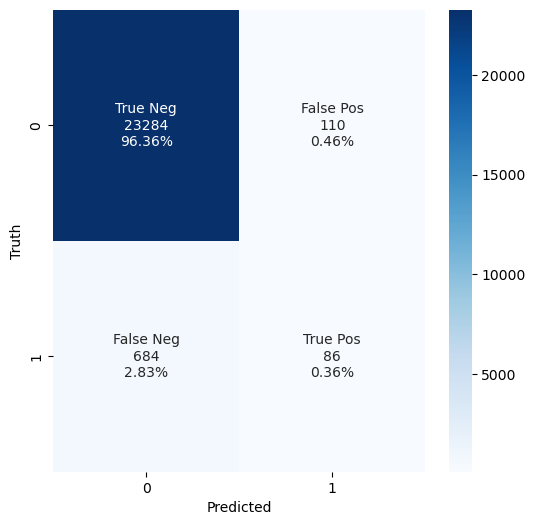

In [60]:
plot_cm(y_test,clean_preds(cnn_model,X_test))

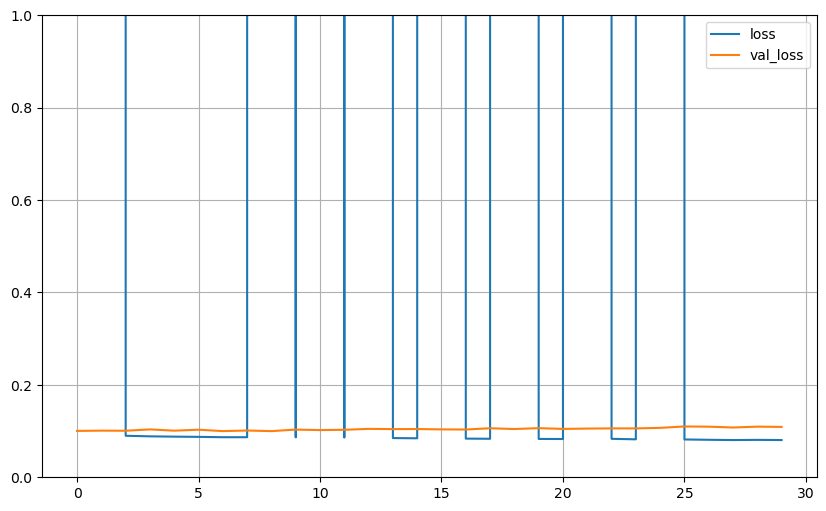

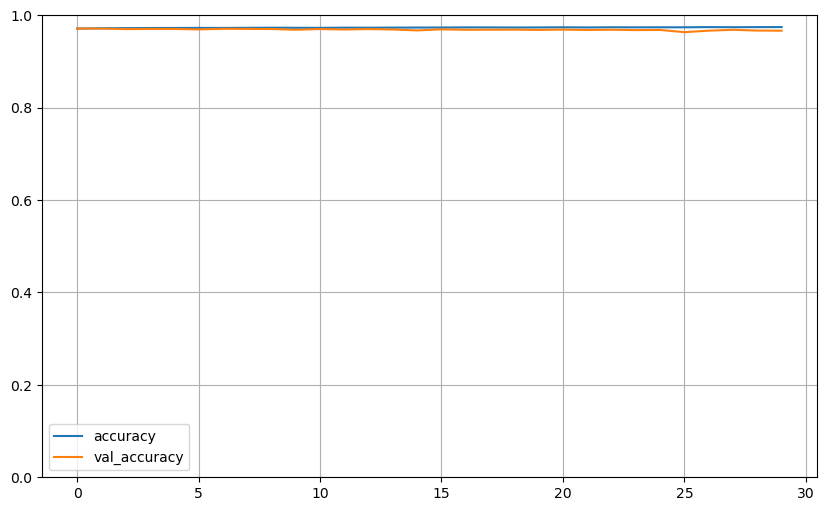

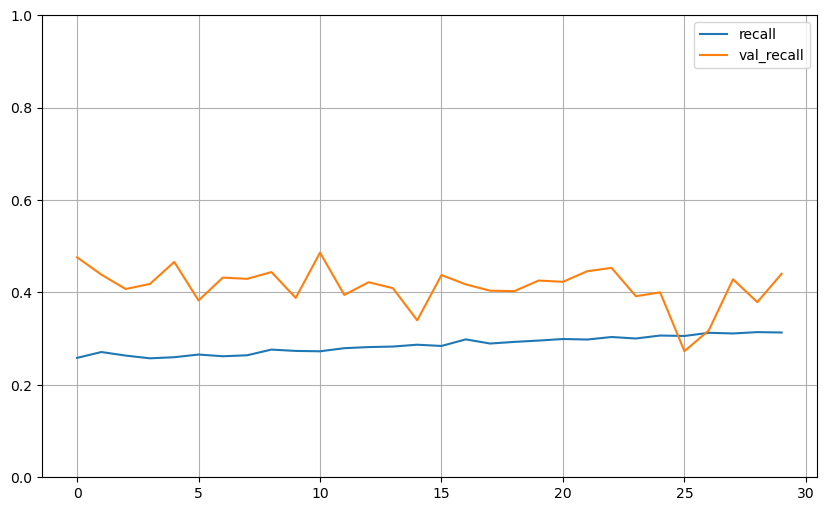

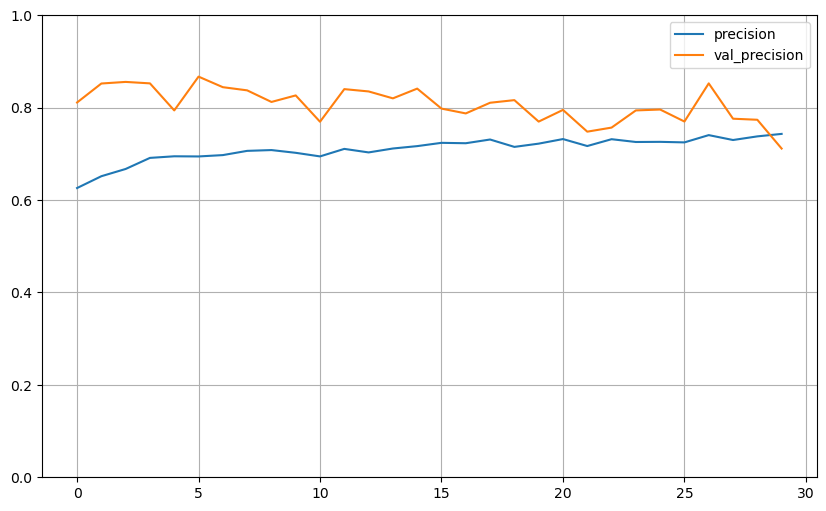

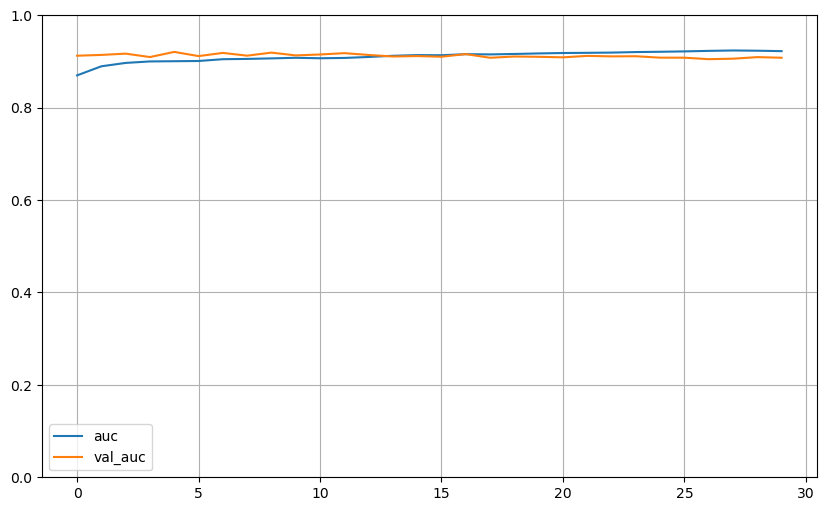

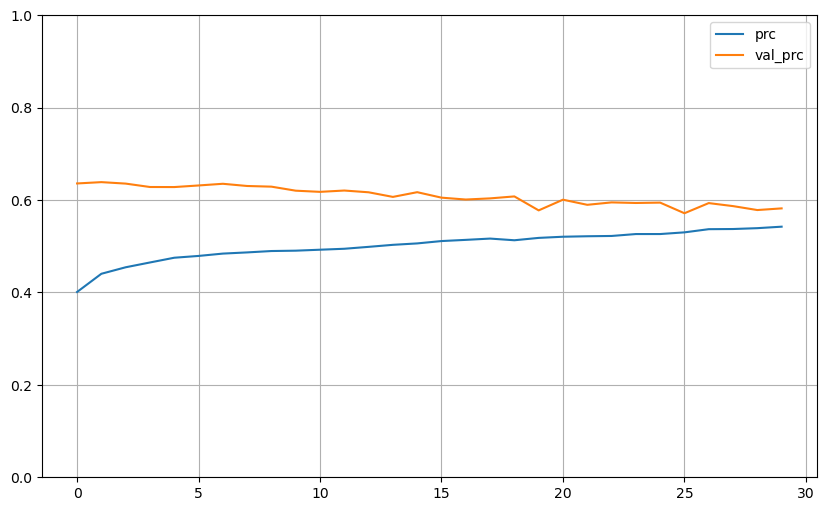

In [62]:
for m in metrics_list:
    plot(CNN_history,m)

### LSTM

In [63]:
lstm_model=build_lstm(TIMESTEPS,FEATURES,OUTPUT)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 4, 128)           41472     
 l)                                                              
                                                                 
 lstm_11 (LSTM)              (None, 32)                20608     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 62,113
Trainable params: 62,113
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
lstm_history=lstm_model.fit(X_train,y_train,epochs=30,batch_size=32,validation_data=(X_val,y_val),class_weight=class_weight)

Epoch 1/30
6075/6075 [==============================] - 65s 10ms/step - loss: 0.0897 - accuracy: 0.9635 - precision: 0.4672 - recall: 0.9731 - auc: 0.9940 - prc: 0.8838 - val_loss: 0.3546 - val_accuracy: 0.9245 - val_precision: 0.3242 - val_recall: 0.6181 - val_auc: 0.8278 - val_prc: 0.4204
Epoch 2/30
6075/6075 [==============================] - 63s 10ms/step - loss: 0.0719 - accuracy: 0.9683 - precision: 0.5036 - recall: 0.9805 - auc: 0.9960 - prc: 0.9135 - val_loss: 0.3638 - val_accuracy: 0.9193 - val_precision: 0.3057 - val_recall: 0.6181 - val_auc: 0.8308 - val_prc: 0.4113
Epoch 3/30
6075/6075 [==============================] - 64s 10ms/step - loss: 0.0593 - accuracy: 0.9717 - precision: 0.5325 - recall: 0.9859 - auc: 0.9971 - prc: 0.9274 - val_loss: 0.3505 - val_accuracy: 0.9306 - val_precision: 0.3440 - val_recall: 0.5907 - val_auc: 0.8268 - val_prc: 0.4296
Epoch 4/30
6075/6075 [==============================] - 64s 11ms/step - loss: 0.0637 - accuracy: 0.9710 - precision: 0.5259 

In [74]:
lstm_model.evaluate(X_test,y_test)

756/756 [==============================] - 4s 6ms/step - loss: 0.4071 - accuracy: 0.9430 - precision: 0.2079 - recall: 0.2805 - auc: 0.7015 - prc: 0.1300


[0.40711575746536255,
 0.94301438331604,
 0.20789220929145813,
 0.2805194854736328,
 0.7014937996864319,
 0.12997379899024963]

756/756 [==============================] - 3s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     23394
           1       0.21      0.28      0.24       770

    accuracy                           0.94     24164
   macro avg       0.59      0.62      0.60     24164
weighted avg       0.95      0.94      0.95     24164



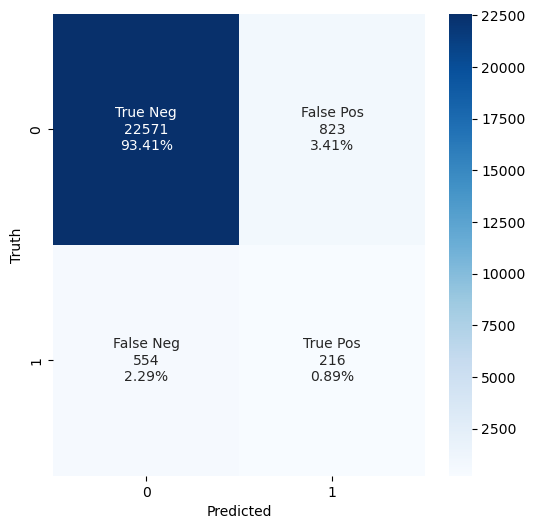

In [75]:
plot_cm(y_test,clean_preds(lstm_model,X_test))

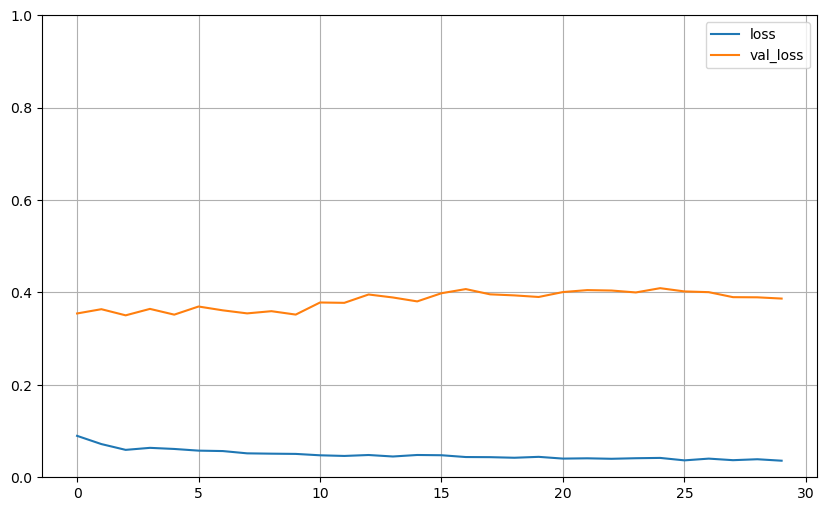

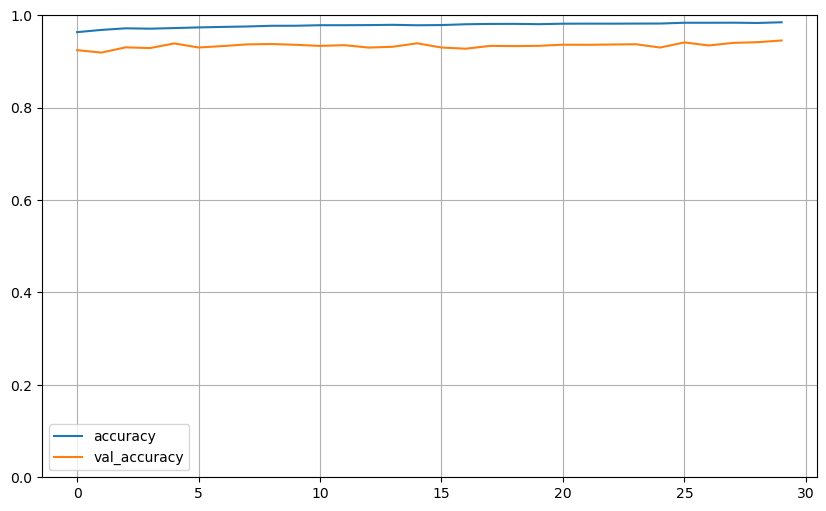

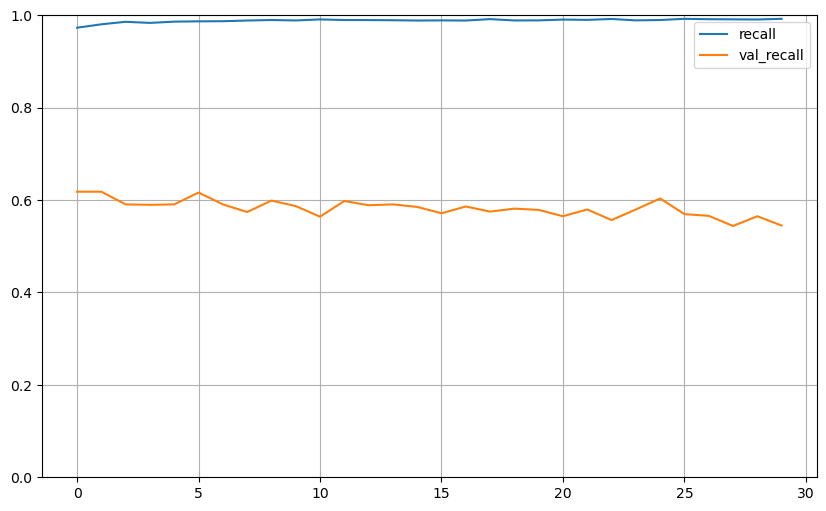

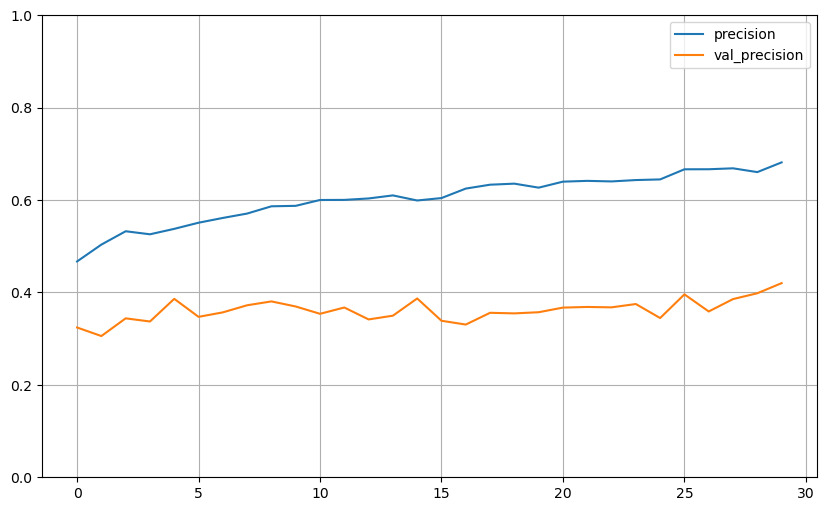

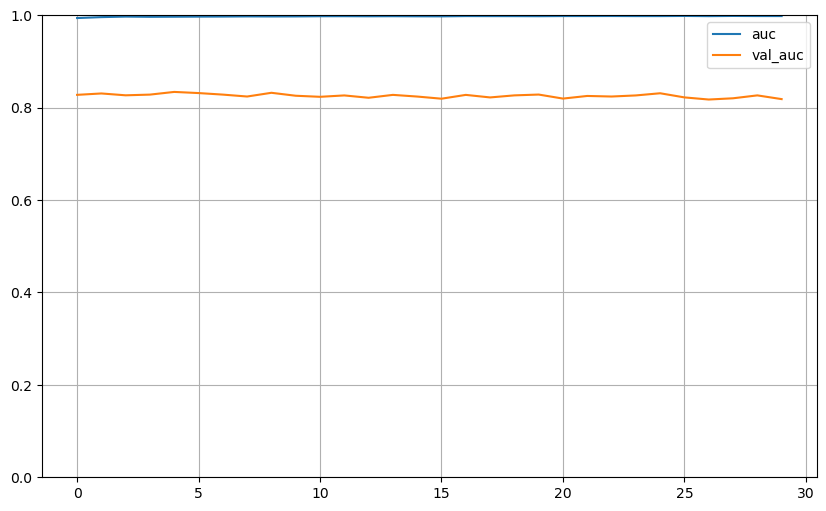

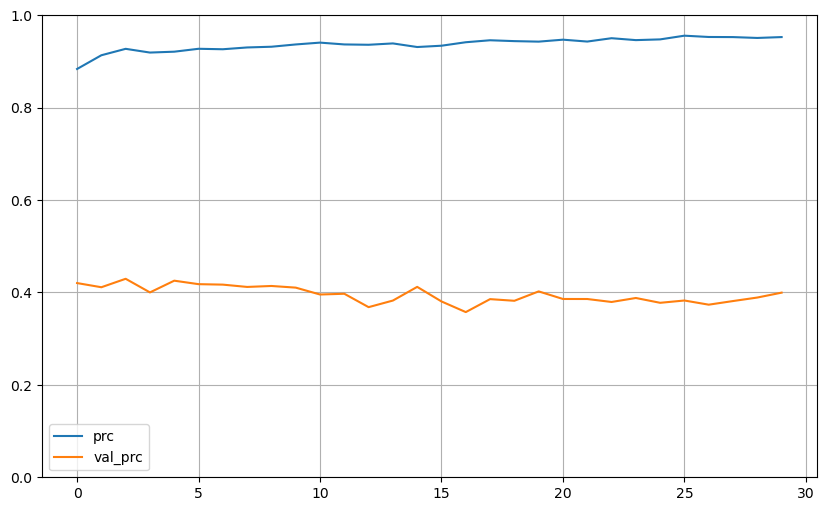

In [76]:
for m in metrics_list:
    plot(lstm_history,m)

### GRU

In [77]:
gru_model=build_gru(TIMESTEPS,FEATURES,OUTPUT)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 4, 128)           31488     
 nal)                                                            
                                                                 
 gru_3 (GRU)                 (None, 32)                15552     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 47,073
Trainable params: 47,073
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
gru_history=gru_model.fit(X_train,y_train,epochs=30,batch_size=32,validation_data=(X_val,y_val),class_weight=class_weight)

Epoch 1/30
6075/6075 [==============================] - 68s 10ms/step - loss: 0.3949 - accuracy: 0.8712 - precision: 0.1730 - recall: 0.7955 - auc: 0.8907 - prc: 0.4237 - val_loss: 0.3340 - val_accuracy: 0.8681 - val_precision: 0.2347 - val_recall: 0.8480 - val_auc: 0.9225 - val_prc: 0.6378
Epoch 2/30
6075/6075 [==============================] - 58s 10ms/step - loss: 0.3787 - accuracy: 0.8652 - precision: 0.1686 - recall: 0.8133 - auc: 0.9010 - prc: 0.4369 - val_loss: 0.3728 - val_accuracy: 0.8602 - val_precision: 0.2248 - val_recall: 0.8544 - val_auc: 0.9254 - val_prc: 0.6331
Epoch 3/30
6075/6075 [==============================] - 60s 10ms/step - loss: 0.3739 - accuracy: 0.8684 - precision: 0.1729 - recall: 0.8187 - auc: 0.9042 - prc: 0.4469 - val_loss: 0.3517 - val_accuracy: 0.8611 - val_precision: 0.2257 - val_recall: 0.8526 - val_auc: 0.9252 - val_prc: 0.6401
Epoch 4/30
6075/6075 [==============================] - 60s 10ms/step - loss: 0.3678 - accuracy: 0.8694 - precision: 0.1742 

In [79]:
gru_model.evaluate(X_test,y_test)

756/756 [==============================] - 4s 5ms/step - loss: 0.2837 - accuracy: 0.9265 - precision: 0.2130 - recall: 0.4844 - auc: 0.7844 - prc: 0.1880


[0.2837437689304352,
 0.9265435934066772,
 0.21302112936973572,
 0.48441559076309204,
 0.7843647003173828,
 0.18799881637096405]

756/756 [==============================] - 3s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     23394
           1       0.21      0.48      0.30       770

    accuracy                           0.93     24164
   macro avg       0.60      0.71      0.63     24164
weighted avg       0.96      0.93      0.94     24164



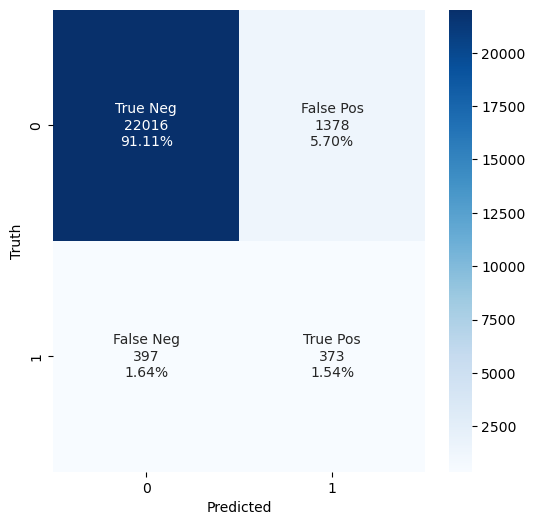

In [80]:
plot_cm(y_test,clean_preds(gru_model,X_test))

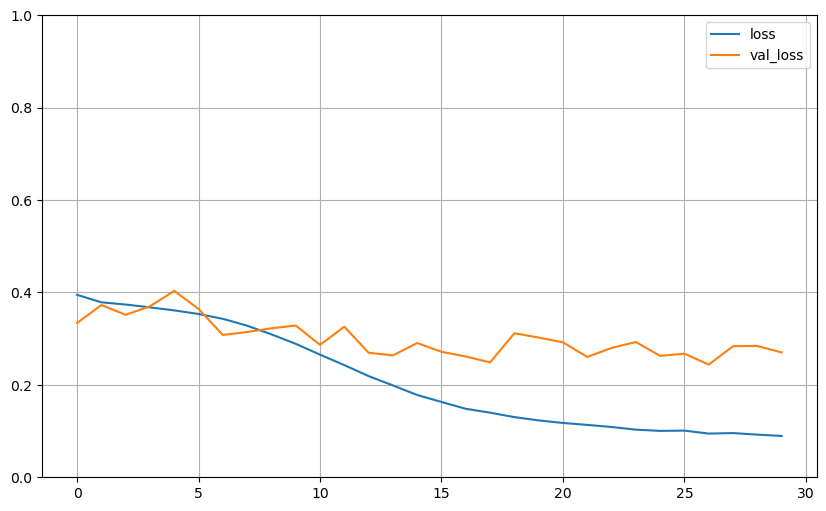

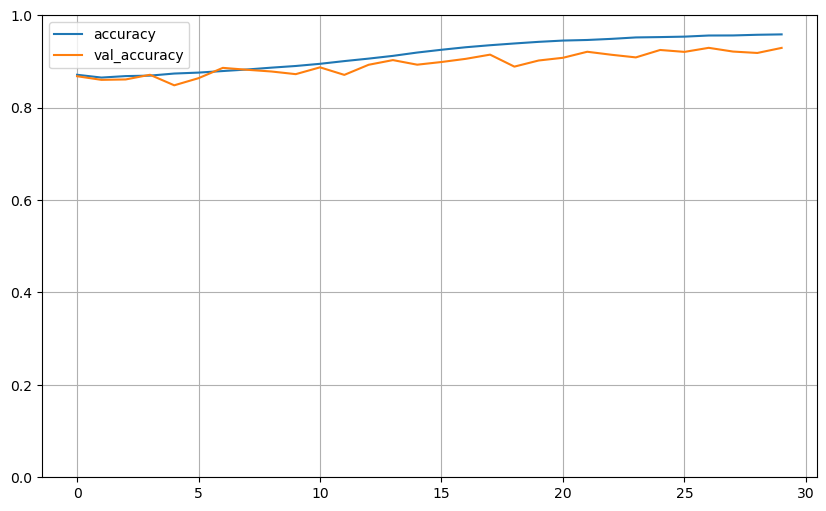

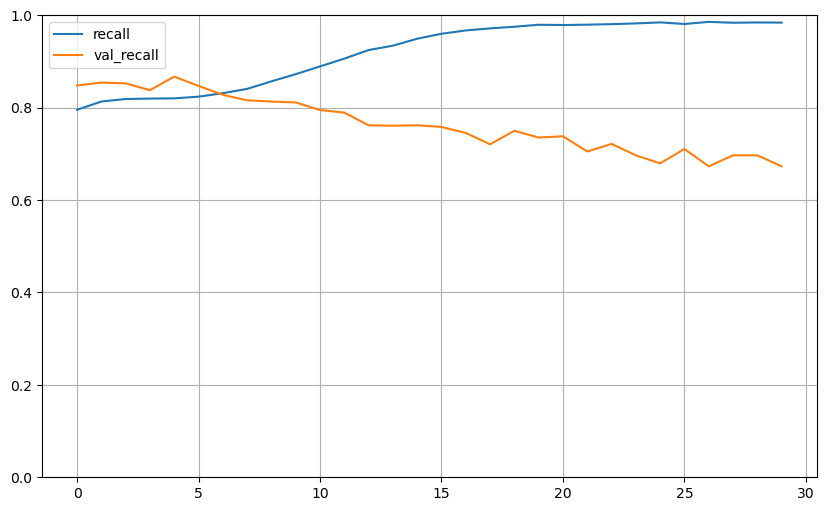

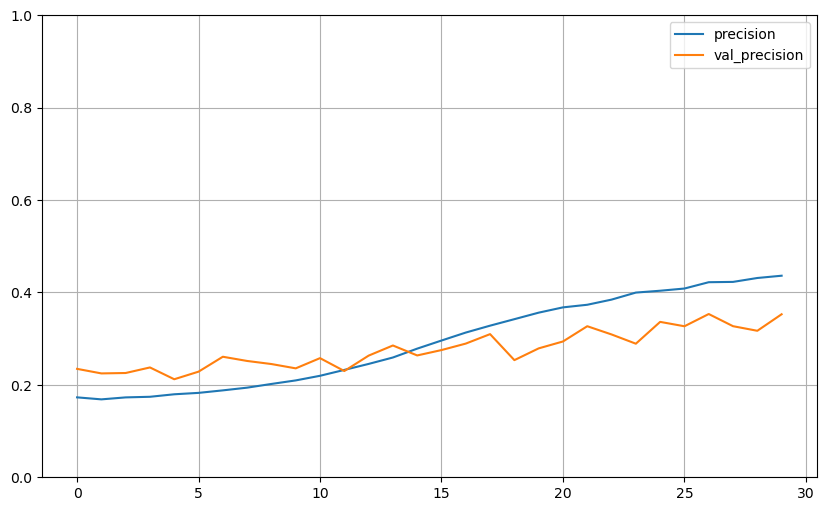

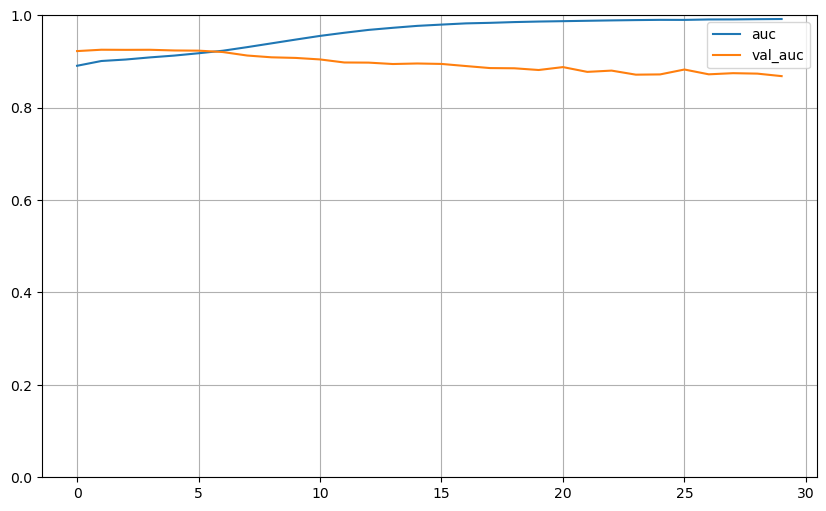

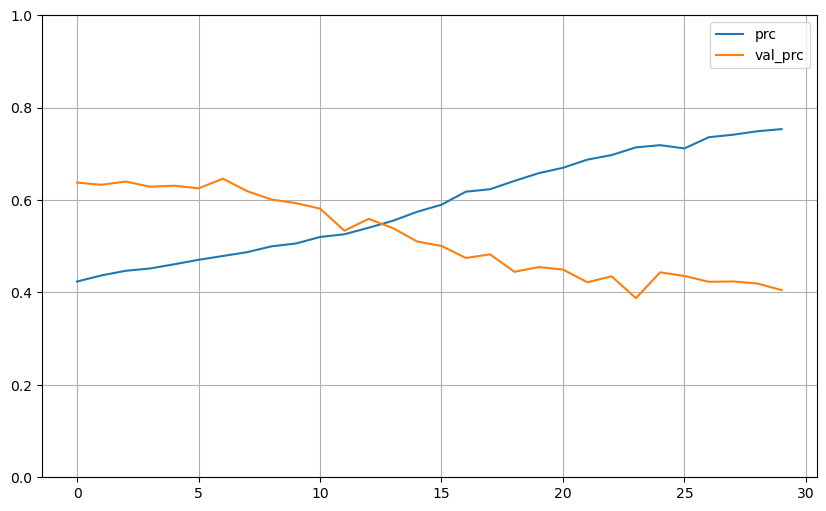

In [81]:
for m in metrics_list:
    plot(gru_history,m)

## Hyperparameters tunning using Keras-Tuner

In [18]:
! pip install keras-tuner

- prc maximization forgot to add class_weight

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

def build_model(hp):
    n_static = 4
    n_timesteps = 4
    n_dynamic = 12
    n_output = 1

    recurrent_input = keras.Input(shape=(n_timesteps, n_dynamic), name="TIMESERIES_INPUT")
    static_input = keras.Input(shape=(n_static, ), name="STATIC_INPUT")

    rec_layer_one = layers.Bidirectional(layers.LSTM(
        units=hp.Int('lstm_units_1', min_value=64, max_value=256, step=32),
        kernel_regularizer=l2(hp.Choice('l2_1', values=[0.01, 0.001, 0.0001])),
        recurrent_regularizer=l2(hp.Choice('l2_2', values=[0.01, 0.001, 0.0001])),
        return_sequences=True
    ), name="BIDIRECTIONAL_LAYER_1")(recurrent_input)
    rec_layer_one = layers.Dropout(hp.Choice('dropout_1', values=[0.1, 0.2, 0.3]), name="DROPOUT_LAYER_1")(rec_layer_one)

    rec_layer_two = layers.Bidirectional(layers.LSTM(
        units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32),
        kernel_regularizer=l2(hp.Choice('l2_3', values=[0.01, 0.001, 0.0001])),
        recurrent_regularizer=l2(hp.Choice('l2_4', values=[0.01, 0.001, 0.0001]))
    ), name="BIDIRECTIONAL_LAYER_2")(rec_layer_one)
    rec_layer_two = layers.Dropout(hp.Choice('dropout_2', values=[0.1, 0.2, 0.3]), name="DROPOUT_LAYER_2")(rec_layer_two)

    static_layer_one = layers.Dense(
        units=hp.Int('dense_units_1', min_value=32, max_value=128, step=32),
        kernel_regularizer=l2(hp.Choice('l2_5', values=[0.01, 0.001, 0.0001])),
        activation=hp.Choice('activation_1', values=['relu', 'tanh']),
        name="DENSE_LAYER_1"
    )(static_input)

    combined = layers.Concatenate(axis=1, name="CONCATENATED_TIMESERIES_STATIC")([rec_layer_two, static_layer_one])
    combined_dense_two = layers.Dense(
        units=hp.Int('dense_units_2', min_value=32, max_value=128, step=32),
        activation=hp.Choice('activation_2', values=['relu', 'tanh']),
        name="DENSE_LAYER_2"
    )(combined)

    output = layers.Dense(n_output, activation='sigmoid', name="OUTPUT_LAYER")(combined_dense_two)

    model = keras.Model(inputs=[recurrent_input, static_input], outputs=[output])
    model.compile(
        loss='binary_crossentropy', 
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        metrics=[
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.AUC(name='prc', curve='PR')
        ]
    )
    return model

# Early stopping for prc
early_stopping_prc = keras.callbacks.EarlyStopping(
    monitor='val_prc',
    patience=5,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

# Model checkpoint for prc
checkpoint_prc = keras.callbacks.ModelCheckpoint(
    "best_weights_prc.h5", 
    monitor='val_prc', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

callbacks_list = [early_stopping_prc, checkpoint_prc]

tuner = RandomSearch(
    build_model,
    objective=Objective('val_prc', direction='max'),
    max_trials=30,
    directory='tuning_dir',
    project_name='keras_tuner_example'
)

tuner.search(
    x=[X_train[:, :, 4:], X_train_static], 
    y=y_train,
    epochs=30,
    batch_size=32,
    validation_data=([X_val[:, :, 4:], X_val_static], y_val),
    callbacks=callbacks_list
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save("best_model.h5")


Trial 30 Complete [00h 16m 58s]
val_prc: 0.6451799273490906

Best val_prc So Far: 0.6548445224761963
Total elapsed time: 05h 47m 26s


In [36]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 4, 12)]      0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (Bidirec  (None, 4, 384)      314880      ['TIMESERIES_INPUT[0][0]']       
 tional)                                                                                          
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 4, 384)       0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (Bidirec  (None, 64)          106752      ['DROPOUT_LAYER_1[0][0]']    

In [28]:
best_model.evaluate([X_test[:,:,4:],X_test_static],y_test)

756/756 [==============================] - 7s 7ms/step - loss: 0.1039 - accuracy: 0.9681 - precision: 0.5000 - recall: 0.0792 - auc: 0.8636 - prc: 0.2914


[0.10388198494911194,
 0.9681344032287598,
 0.5,
 0.07922077924013138,
 0.8636226058006287,
 0.29144158959388733]

756/756 [==============================] - 5s 4ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     23394
           1       0.50      0.08      0.14       770

    accuracy                           0.97     24164
   macro avg       0.74      0.54      0.56     24164
weighted avg       0.96      0.97      0.96     24164



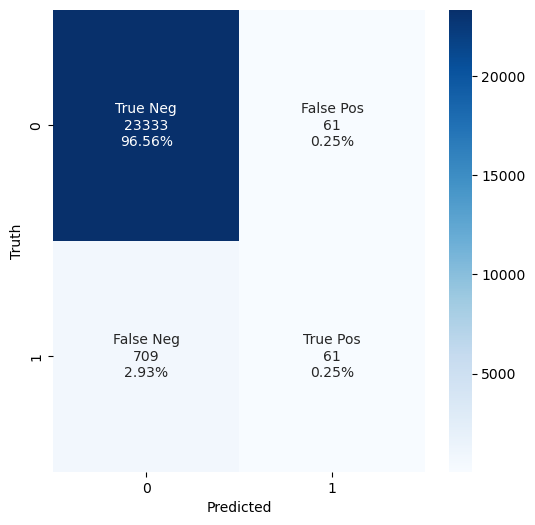

In [34]:
plot_cm(y_test,clean_preds(best_model,[X_test[:,:,4:],X_test_static]))

### Tomorrow run it for recall with less trials and compare both to save results best model weights

## Handling Imbalanced Datasets With imblearn Library

In [79]:
#separate target and features
# X=train_data.drop('stroke',axis=1)
# y=train_data['stroke']
# print(X.shape[0])
# X=X.set_index('CHARTTIME')

### Oversampling

In [80]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=0)
# X_resampled, y_resampled = sm.fit_resample(X, y)
# target=pd.DataFrame({"stroke":y_resampled.values})
# print(target['stroke'].value_counts())
# oversampled_df=pd.concat([X_resampled,target],axis=1)

### Undersampling

In [81]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X, y)